['/Users/souchaud/Desktop/Analyses/CytoOne_HL5_10x_results_tracking/2024_05_02_ASMOT158_AX3_2024_P4_10x_CytoOne_HL5_2904-12h45_0205_13h30/mosaic/filtered_final.hdf5']
ASMOT158  :  779
['/Users/souchaud/Desktop/Analyses/CytoOne_HL5_10x_results_tracking/2024_03_06_ASMOT134_AX3_MAT_P3_10x_CytoOne_HL5_0403-15h-0603-12h07/mosaic/filtered_final.hdf5']
ASMOT134  :  45
['/Users/souchaud/Desktop/Analyses/CytoOne_HL5_10x_results_tracking/2024_02_21_ASMOT128_AX3_MAT_P5_10x_CytoOne_HL5_1902-11h-2102-9h10_1/mosaic/filtered_final.hdf5']
ASMOT128  :  113
['/Users/souchaud/Desktop/Analyses/CytoOne_HL5_10x_results_tracking/2024_03_26_ASMOT144_AX3_2024_P1_10x_CytoOne_HL5_2603-17h00-2703-14h25/mosaic/filtered_final.hdf5']
ASMOT144  :  94
['/Users/souchaud/Desktop/Analyses/CytoOne_HL5_10x_results_tracking/2024_03_06_ASMOT135_AX3_MAT_P3_10x_CytoOne_HL5_0403-15h-0603-15h07/mosaic/filtered_final.hdf5']
ASMOT135  :  70
['/Users/souchaud/Desktop/Analyses/CytoOne_HL5_10x_results_tracking/2024_05_28_ASMOT179_AX3

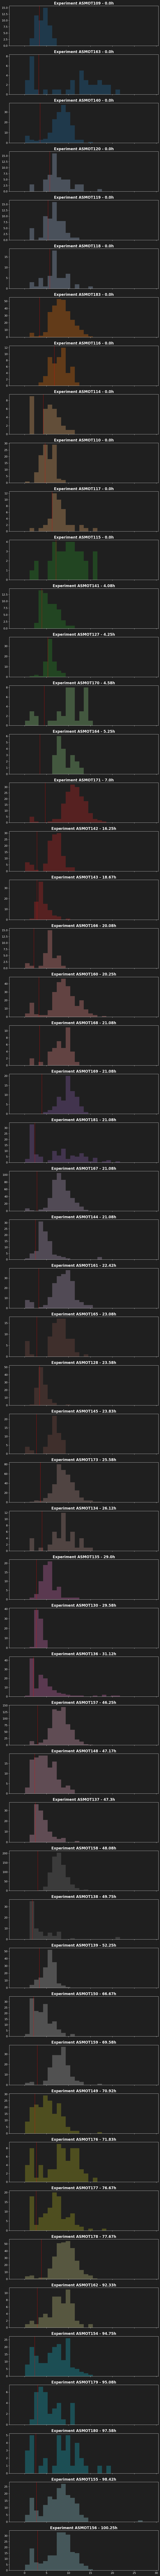

In [5]:
import os
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import trackpy as tp
import functions_analyze as lib
from typing import List, Dict
from matplotlib import colormaps

# Initialize
INITIAL_TIME = time.time()

# Experiment Parameters
TIME_FRAME = 15
SIZE_PIX = 0.637
FPS = 1 / TIME_FRAME

# General Paths
GENERAL_PATH = '/Users/souchaud/Desktop/Analyses/'
CONDITION_SIMPLE = 'CytoOne_HL5_10x'
CONDITION = f'{CONDITION_SIMPLE}_results_tracking'
PATHWAY_EXPERIMENT = [os.path.join(GENERAL_PATH, CONDITION, f, 'mosaic')
                      for f in os.listdir(os.path.join(GENERAL_PATH, CONDITION))
                      if os.path.isdir(os.path.join(GENERAL_PATH, CONDITION, f))]

path_save_pic = os.path.join(GENERAL_PATH, f'résultats_{CONDITION}_All')
os.makedirs(path_save_pic, exist_ok=True)

# Add Incubation Times to Data
conditions_to_values = {
    'ASMOT127': 4.25, 'ASMOT128': 23.58, 'ASMOT130': 29.58, 'ASMOT132': 4.33, 'ASMOT133': 23.12,
    'ASMOT134': 26.12, 'ASMOT135': 29, 'ASMOT136': 31.12, 'ASMOT137': 47.3, 'ASMOT138': 49.75,
    'ASMOT139': 52.25, 'ASMOT140': 0, 'ASMOT141': 4.08, 'ASMOT142': 16.25, 'ASMOT143': 18.67,
    'ASMOT144': 21.08, 'ASMOT145': 23.83, 'ASMOT146': 42.17, 'ASMOT147': 51.17, 'ASMOT148': 47.17,
    'ASMOT149': 70.92, 'ASMOT150': 66.67, 'ASMOT151': 71.17, 'ASMOT152': 76.33, 'ASMOT153': 78.33,
    'ASMOT154': 94.75, 'ASMOT155': 98.42, 'ASMOT156': 100.25, 'ASMOT157': 46.25, 'ASMOT158': 48.08,
    'ASMOT159': 69.58, 'ASMOT160': 20.25, 'ASMOT161': 22.42, 'ASMOT162': 92.33, 'ASMOT163': 0.0,
    'ASMOT164': 5.25, 'ASMOT165': 23.08, 'ASMOT166': 20.08, 'ASMOT167': 21.08, 'ASMOT168': 21.08,
    'ASMOT169': 21.08, 'ASMOT170': 4.58, 'ASMOT171': 7.00, 'ASMOT172': 24.00, 'ASMOT173': 25.58,
    'ASMOT174': 30.58, 'ASMOT175': 47.58, 'ASMOT176': 71.83, 'ASMOT177': 76.67, 'ASMOT178': 77.67,
    'ASMOT179': 95.08, 'ASMOT180': 97.58, 'ASMOT181': 21.08,
}

# Load Data
def load_data():
    data = lib.read_hdf5_all(
        pathway_experiment=PATHWAY_EXPERIMENT,
        name_file='filtered_final',
        nbr_frame_min=200,
        condition=CONDITION,
        drift=False,
        search_range=20,
        memory=5
    )
    data.sort_values(by='frame', inplace=True)
    data = data[data['frame'] < 340]
    data['time to incubation (hours)'] = data['experiment'].map(conditions_to_values).fillna(0.0)
    return data

DATA = load_data()

# Analysis
def analyze_data(data: pd.DataFrame):
    data['time (min)'] = data['frame'] * TIME_FRAME / 60
    data = lib.vit_instant_new(traj=data, lag_time=TIME_FRAME, pix_size=SIZE_PIX, triage=1)

    # Cumulative displacement
    data['cumulative displacement [um]'] = data.groupby('particle')['displacement [pix]'].cumsum() * SIZE_PIX

    # Start-End displacement
    start_end = pd.DataFrame()
    start_end['start-end [um]'] = SIZE_PIX * np.sqrt(
        data.groupby('particle').apply(lib.subtract_first_last, 'x')**2 +
        data.groupby('particle').apply(lib.subtract_first_last, 'y')**2
    )

    # Velocity medians
    medians = data.groupby('experiment')['VitInst [um/min]'].median()

    return data, start_end, medians

DATA, start_end, medians = analyze_data(DATA)

# Visualization
exp_hours = DATA.groupby('experiment')[['time to incubation (hours)']].first().reset_index()
def plot_velocity_histograms(all_mean_vitinst, medians, exp_hours):
    exp_hours_sorted = exp_hours.sort_values(by='time to incubation (hours)').reset_index(drop=True)
    experiments = exp_hours_sorted['experiment'].tolist()

    n_experiments = len(experiments)
    fig, axes = plt.subplots(n_experiments, 1, figsize=(10, 3 * n_experiments), sharex=True)
    axes = np.atleast_1d(axes)

    global_min = all_mean_vitinst['VitInst [um/min]'].min()
    global_max = all_mean_vitinst['VitInst [um/min]'].max()
    delta = (global_max - global_min) * 0.1
    global_min -= delta
    global_max += delta

    palette = colormaps['tab20']
    colors = [palette(i / n_experiments) for i in range(n_experiments)]

    for idx, ax in enumerate(axes):
        exp = experiments[idx]
        hour = exp_hours_sorted.iloc[idx]['time to incubation (hours)']

        data_exp = all_mean_vitinst[all_mean_vitinst['experiment'] == exp]
        ax.hist(
            data_exp['VitInst [um/min]'],
            bins=30,
            alpha=0.3,
            range=(global_min, global_max),
            color=colors[idx]
        )
        ax.set_title(f'Experiment {exp} - {hour}h')
        ax.axvline(medians.loc[exp], color='red', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.show()

all_mean_vitinst = DATA.groupby(['experiment', 'particle'])['VitInst [um/min]'].mean().reset_index()
plot_velocity_histograms(all_mean_vitinst, medians, exp_hours)


['/Users/souchaud/Desktop/Analyses/CytoOne_HL5_10x_results_tracking/2024_05_02_ASMOT158_AX3_2024_P4_10x_CytoOne_HL5_2904-12h45_0205_13h30/mosaic/filtered_final.hdf5']
ASMOT158  :  779
['/Users/souchaud/Desktop/Analyses/CytoOne_HL5_10x_results_tracking/2024_03_06_ASMOT134_AX3_MAT_P3_10x_CytoOne_HL5_0403-15h-0603-12h07/mosaic/filtered_final.hdf5']
ASMOT134  :  45
['/Users/souchaud/Desktop/Analyses/CytoOne_HL5_10x_results_tracking/2024_02_21_ASMOT128_AX3_MAT_P5_10x_CytoOne_HL5_1902-11h-2102-9h10_1/mosaic/filtered_final.hdf5']
ASMOT128  :  113
['/Users/souchaud/Desktop/Analyses/CytoOne_HL5_10x_results_tracking/2024_03_26_ASMOT144_AX3_2024_P1_10x_CytoOne_HL5_2603-17h00-2703-14h25/mosaic/filtered_final.hdf5']
ASMOT144  :  94
['/Users/souchaud/Desktop/Analyses/CytoOne_HL5_10x_results_tracking/2024_03_06_ASMOT135_AX3_MAT_P3_10x_CytoOne_HL5_0403-15h-0603-15h07/mosaic/filtered_final.hdf5']
ASMOT135  :  70
['/Users/souchaud/Desktop/Analyses/CytoOne_HL5_10x_results_tracking/2024_05_28_ASMOT179_AX3

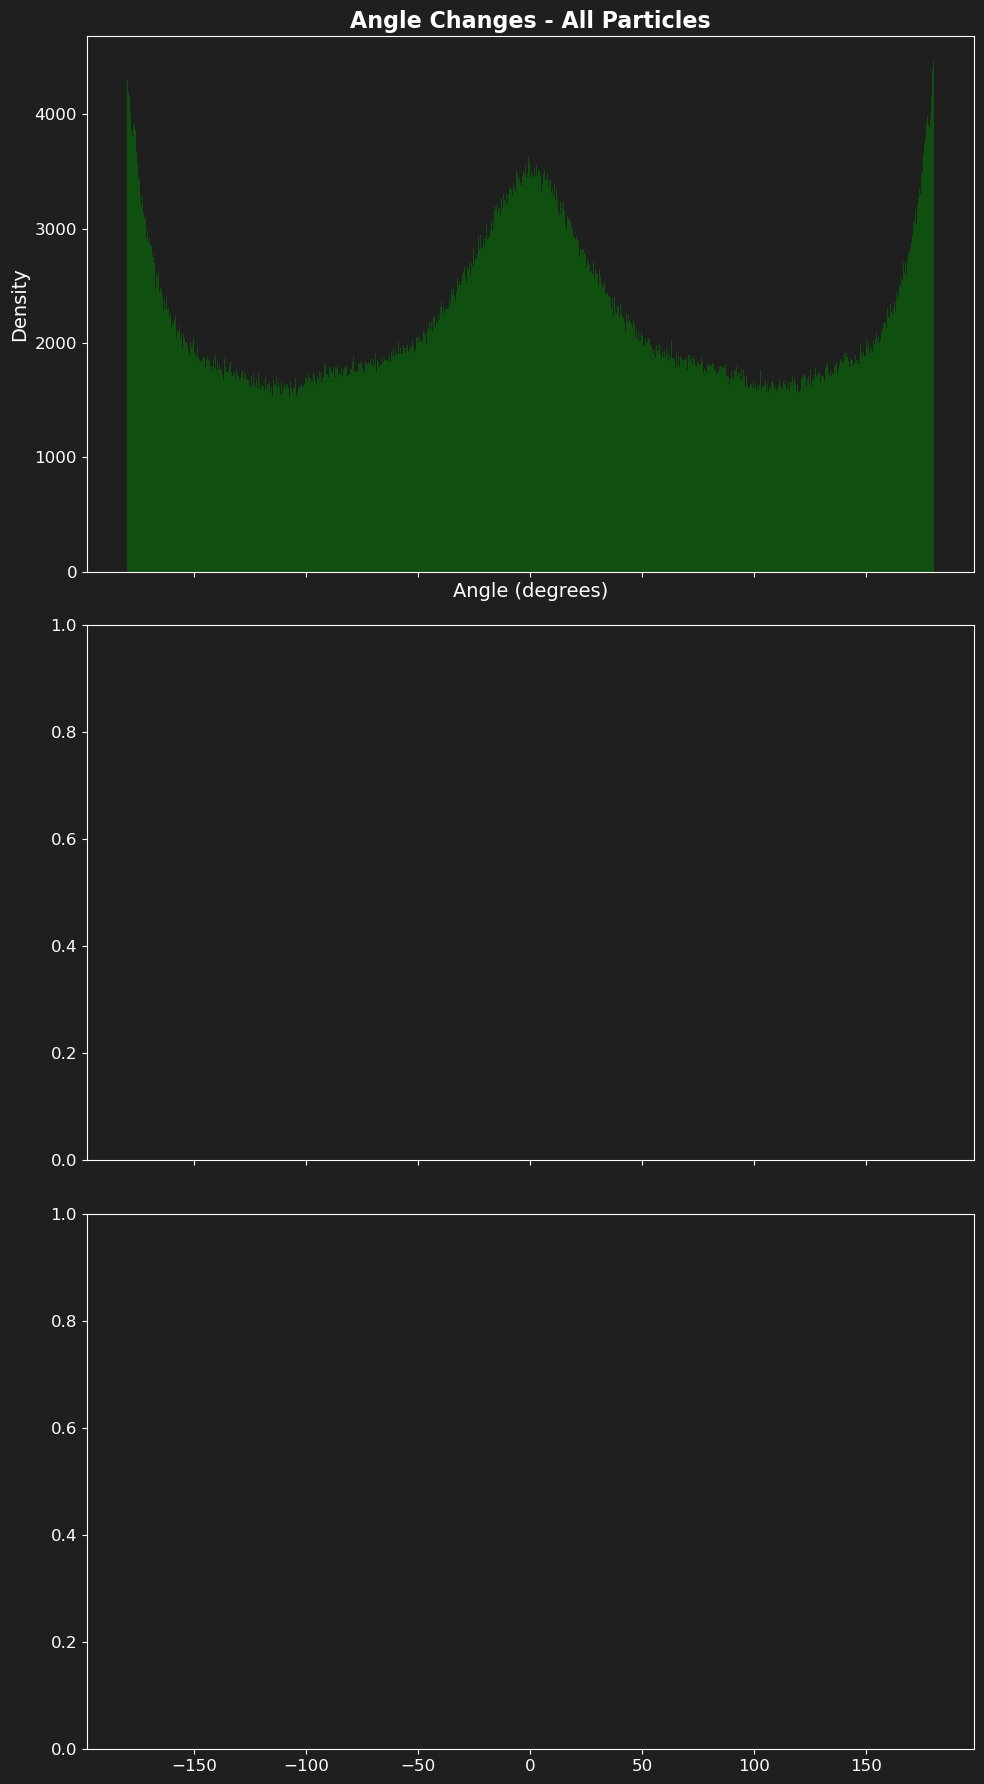

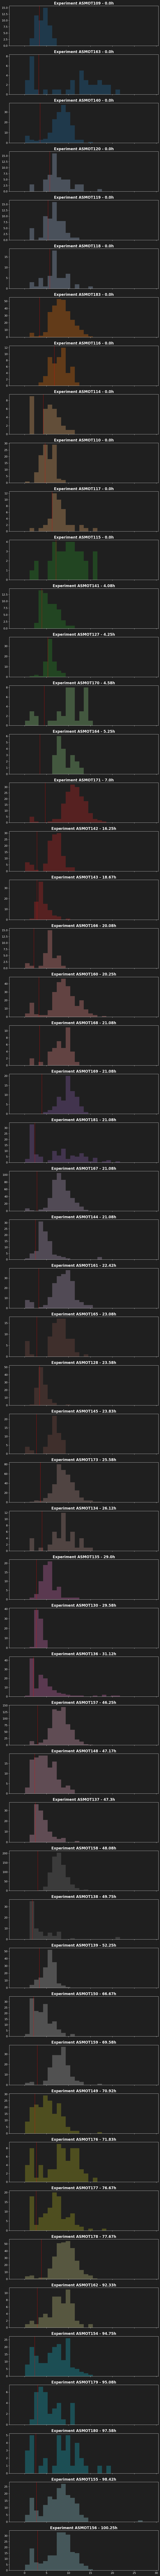

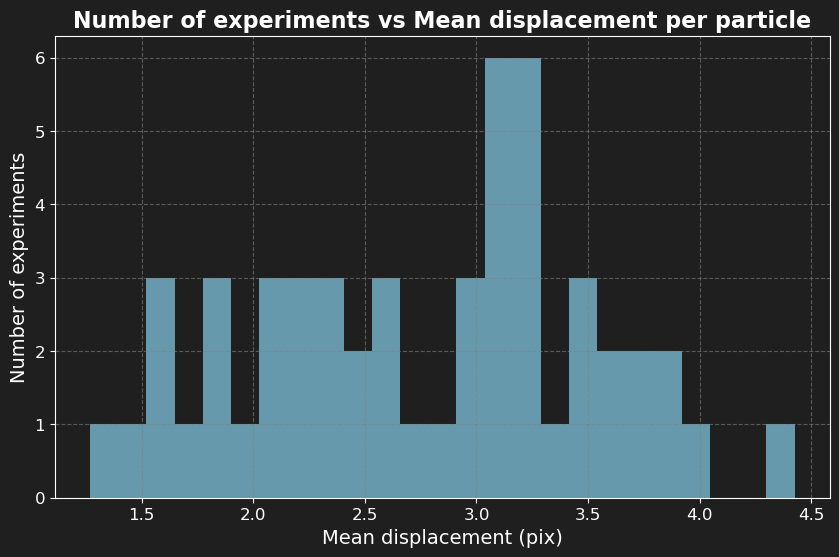

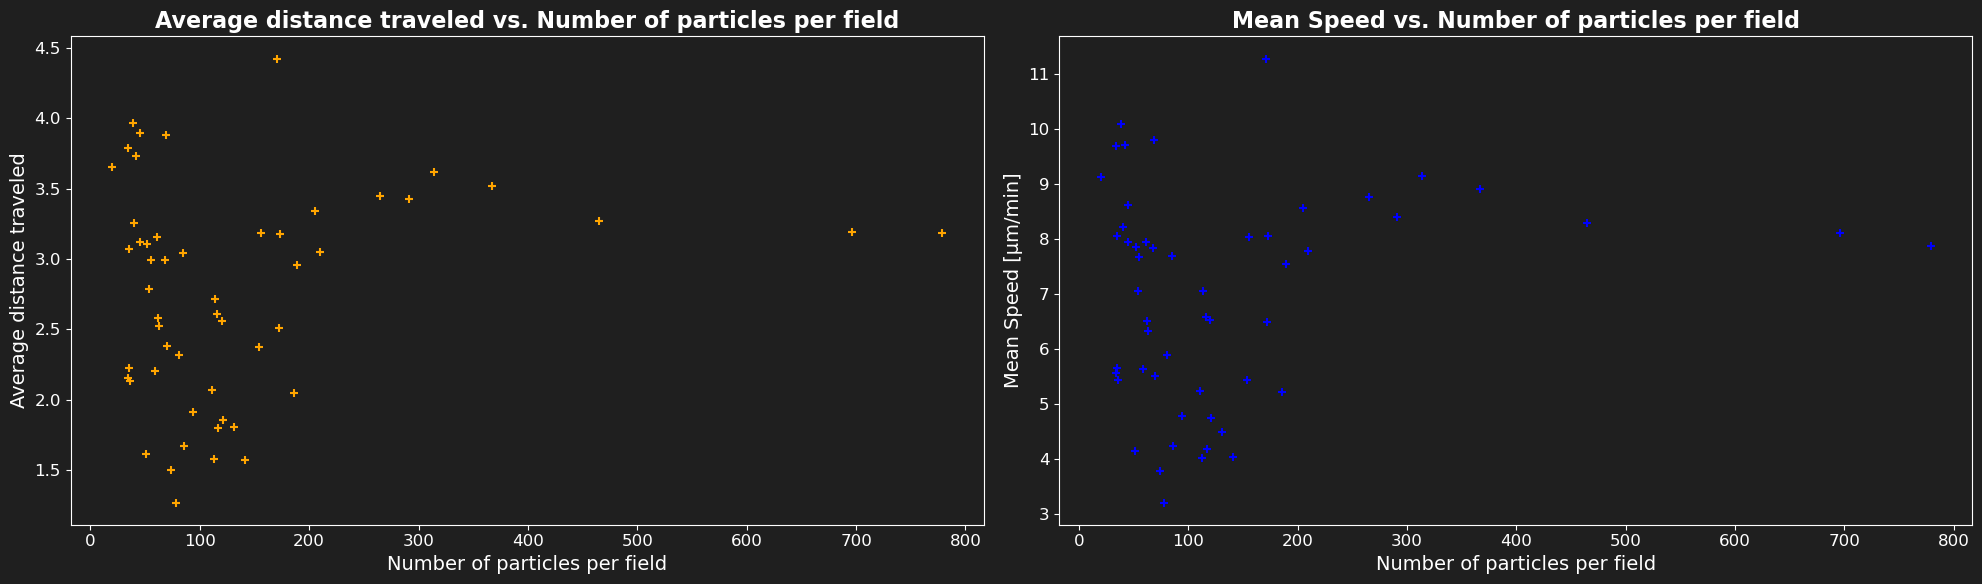

In [6]:
import os
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import trackpy as tp
import functions_analyze as lib
from typing import List, Dict
from matplotlib import colormaps

# Initialize
INITIAL_TIME = time.time()

# Experiment Parameters
TIME_FRAME = 15
SIZE_PIX = 0.637
FPS = 1 / TIME_FRAME

# General Paths
GENERAL_PATH = '/Users/souchaud/Desktop/Analyses/'
CONDITION_SIMPLE = 'CytoOne_HL5_10x'
CONDITION = f'{CONDITION_SIMPLE}_results_tracking'
PATHWAY_EXPERIMENT = [os.path.join(GENERAL_PATH, CONDITION, f, 'mosaic')
                      for f in os.listdir(os.path.join(GENERAL_PATH, CONDITION))
                      if os.path.isdir(os.path.join(GENERAL_PATH, CONDITION, f))]

path_save_pic = os.path.join(GENERAL_PATH, f'résultats_{CONDITION}_All')
os.makedirs(path_save_pic, exist_ok=True)

# Add Incubation Times to Data
conditions_to_values = {
    'ASMOT127': 4.25, 'ASMOT128': 23.58, 'ASMOT130': 29.58, 'ASMOT132': 4.33, 'ASMOT133': 23.12,
    'ASMOT134': 26.12, 'ASMOT135': 29, 'ASMOT136': 31.12, 'ASMOT137': 47.3, 'ASMOT138': 49.75,
    'ASMOT139': 52.25, 'ASMOT140': 0, 'ASMOT141': 4.08, 'ASMOT142': 16.25, 'ASMOT143': 18.67,
    'ASMOT144': 21.08, 'ASMOT145': 23.83, 'ASMOT146': 42.17, 'ASMOT147': 51.17, 'ASMOT148': 47.17,
    'ASMOT149': 70.92, 'ASMOT150': 66.67, 'ASMOT151': 71.17, 'ASMOT152': 76.33, 'ASMOT153': 78.33,
    'ASMOT154': 94.75, 'ASMOT155': 98.42, 'ASMOT156': 100.25, 'ASMOT157': 46.25, 'ASMOT158': 48.08,
    'ASMOT159': 69.58, 'ASMOT160': 20.25, 'ASMOT161': 22.42, 'ASMOT162': 92.33, 'ASMOT163': 0.0,
    'ASMOT164': 5.25, 'ASMOT165': 23.08, 'ASMOT166': 20.08, 'ASMOT167': 21.08, 'ASMOT168': 21.08,
    'ASMOT169': 21.08, 'ASMOT170': 4.58, 'ASMOT171': 7.00, 'ASMOT172': 24.00, 'ASMOT173': 25.58,
    'ASMOT174': 30.58, 'ASMOT175': 47.58, 'ASMOT176': 71.83, 'ASMOT177': 76.67, 'ASMOT178': 77.67,
    'ASMOT179': 95.08, 'ASMOT180': 97.58, 'ASMOT181': 21.08,
}

# Load Data
def load_data():
    data = lib.read_hdf5_all(
        pathway_experiment=PATHWAY_EXPERIMENT,
        name_file='filtered_final',
        nbr_frame_min=200,
        condition=CONDITION,
        drift=False,
        search_range=20,
        memory=5
    )
    data.sort_values(by='frame', inplace=True)
    data = data[data['frame'] < 340]
    data['time to incubation (hours)'] = data['experiment'].map(conditions_to_values).fillna(0.0)
    return data

DATA = load_data()

# Analysis
def analyze_data(data: pd.DataFrame):
    data['time (min)'] = data['frame'] * TIME_FRAME / 60
    data = lib.vit_instant_new(traj=data, lag_time=TIME_FRAME, pix_size=SIZE_PIX, triage=1)

    # Cumulative displacement
    data['cumulative displacement [um]'] = data.groupby('particle')['displacement [pix]'].cumsum() * SIZE_PIX

    # Start-End displacement
    start_end = pd.DataFrame()
    start_end['start-end [um]'] = SIZE_PIX * np.sqrt(
        data.groupby('particle').apply(lib.subtract_first_last, 'x')**2 +
        data.groupby('particle').apply(lib.subtract_first_last, 'y')**2
    )

    # Velocity medians
    medians = data.groupby('experiment')['VitInst [um/min]'].median()

    return data, start_end, medians

DATA, start_end, medians = analyze_data(DATA)

# Visualization
exp_hours = DATA.groupby('experiment')[['time to incubation (hours)']].first().reset_index()

def plot_velocity_histograms(all_mean_vitinst, medians, exp_hours):
    exp_hours_sorted = exp_hours.sort_values(by='time to incubation (hours)').reset_index(drop=True)
    experiments = exp_hours_sorted['experiment'].tolist()

    n_experiments = len(experiments)
    fig, axes = plt.subplots(n_experiments, 1, figsize=(10, 3 * n_experiments), sharex=True)
    axes = np.atleast_1d(axes)

    global_min = all_mean_vitinst['VitInst [um/min]'].min()
    global_max = all_mean_vitinst['VitInst [um/min]'].max()
    delta = (global_max - global_min) * 0.1
    global_min -= delta
    global_max += delta

    palette = colormaps['tab20']
    colors = [palette(i / n_experiments) for i in range(n_experiments)]

    for idx, ax in enumerate(axes):
        exp = experiments[idx]
        hour = exp_hours_sorted.iloc[idx]['time to incubation (hours)']

        data_exp = all_mean_vitinst[all_mean_vitinst['experiment'] == exp]
        ax.hist(
            data_exp['VitInst [um/min]'],
            bins=30,
            alpha=0.3,
            range=(global_min, global_max),
            color=colors[idx]
        )
        ax.set_title(f'Experiment {exp} - {hour}h')
        ax.axvline(medians.loc[exp], color='red', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.show()

def plot_mean_displacement_histogram(mean_sum, path_save_pic, CONDITION_SIMPLE, IMG_TYPE):
    plt.figure(figsize=(10, 6))
    plt.hist(mean_sum, bins=25, color='skyblue', alpha=0.7)
    plt.title("Number of experiments vs Mean displacement per particle", fontsize=16)
    plt.xlabel("Mean displacement (pix)", fontsize=14)
    plt.ylabel("Number of experiments", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(os.path.join(path_save_pic, f"Mean_displacement_per_particle_{CONDITION_SIMPLE}.{IMG_TYPE}"), format=IMG_TYPE)
    plt.show()

def plot_results_vs_particles(result_df, path_save_pic, CONDITION_SIMPLE, img_type):
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    ax1, ax2 = axes.flatten()
    ax1.scatter(result_df['nombre_part_par_champs'], result_df['mean_sum'], marker='+', color='orange')
    ax1.set_title('Average distance traveled vs. Number of particles per field')
    ax1.set_xlabel('Number of particles per field')
    ax1.set_ylabel('Average distance traveled')
    ax2.scatter(result_df['nombre_part_par_champs'], result_df['mean_speed [um/min]'], marker='+', color='blue')
    ax2.set_title('Mean Speed vs. Number of particles per field')
    ax2.set_xlabel('Number of particles per field')
    ax2.set_ylabel('Mean Speed [μm/min]')
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(path_save_pic, f"Results_vs_particles_{CONDITION_SIMPLE}.{img_type}"), format=img_type)

def compute_angle_changes(df):
    df = df.copy()
    df.sort_values(by=['particle', 'frame'], inplace=True)
    df['dir_x'] = df.groupby('particle')['x'].diff().fillna(0)
    df['dir_y'] = df.groupby('particle')['y'].diff().fillna(0)
    df['dir_x_next'] = df.groupby('particle')['dir_x'].shift(-1)
    df['dir_y_next'] = df.groupby('particle')['dir_y'].shift(-1)
    df.dropna(subset=['dir_x_next', 'dir_y_next'], inplace=True)

    def angle_between_directions(row):
        dx1, dy1 = row['dir_x'], row['dir_y']
        dx2, dy2 = row['dir_x_next'], row['dir_y_next']
        angle_initial = np.arctan2(dy1, dx1)
        angle_final = np.arctan2(dy2, dx2)
        angle_change = angle_final - angle_initial
        angle_change = (angle_change + np.pi) % (2 * np.pi) - np.pi
        return np.degrees(angle_change)

    df['angle_change'] = df.apply(angle_between_directions, axis=1)
    return df

df_sup = compute_angle_changes(DATA[DATA['particle'].isin(DATA['particle'])])

def plot_angle_histograms(df_all):
    fig, axes = plt.subplots(3, 1, figsize=(10, 18), sharex=True)
    axes[0].hist(df_all['angle_change'], bins=1000, alpha=0.5, color='green')
    axes[0].set_title('Angle Changes - All Particles')
    axes[0].set_xlabel('Angle (degrees)')
    axes[0].set_ylabel('Density')

    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(path_save_pic, 'Angle_Changes_Histograms.png'), format='png')

df_all = pd.concat([df_sup])
plot_angle_histograms(df_all)

# Mean instantaneous velocities per particle per experiment
all_mean_vitinst = DATA.groupby(['experiment', 'particle'])['VitInst [um/min]'].mean().reset_index()
plot_velocity_histograms(all_mean_vitinst, medians, exp_hours)

# Mean displacement histogram
mean_sum = DATA.groupby('experiment')['displacement [pix]'].mean()
plot_mean_displacement_histogram(mean_sum, path_save_pic, CONDITION_SIMPLE, 'png')

# Results in function of number of particles per field
result_df = pd.DataFrame({
    'nombre_part_par_champs': DATA.groupby('experiment')['particle'].nunique(),
    'mean_sum': mean_sum,
    'mean_speed [um/min]': all_mean_vitinst.groupby('experiment')['VitInst [um/min]'].mean()
}).reset_index()
plot_results_vs_particles(result_df, path_save_pic, CONDITION_SIMPLE, 'png')


['/Users/souchaud/Desktop/Analyses/CytoOne_HL5_10x_results_tracking/2024_05_02_ASMOT158_AX3_2024_P4_10x_CytoOne_HL5_2904-12h45_0205_13h30/mosaic/filtered_final.hdf5']
ASMOT158  :  779
['/Users/souchaud/Desktop/Analyses/CytoOne_HL5_10x_results_tracking/2024_03_06_ASMOT134_AX3_MAT_P3_10x_CytoOne_HL5_0403-15h-0603-12h07/mosaic/filtered_final.hdf5']
ASMOT134  :  45
['/Users/souchaud/Desktop/Analyses/CytoOne_HL5_10x_results_tracking/2024_02_21_ASMOT128_AX3_MAT_P5_10x_CytoOne_HL5_1902-11h-2102-9h10_1/mosaic/filtered_final.hdf5']
ASMOT128  :  113
['/Users/souchaud/Desktop/Analyses/CytoOne_HL5_10x_results_tracking/2024_03_26_ASMOT144_AX3_2024_P1_10x_CytoOne_HL5_2603-17h00-2703-14h25/mosaic/filtered_final.hdf5']
ASMOT144  :  94
['/Users/souchaud/Desktop/Analyses/CytoOne_HL5_10x_results_tracking/2024_03_06_ASMOT135_AX3_MAT_P3_10x_CytoOne_HL5_0403-15h-0603-15h07/mosaic/filtered_final.hdf5']
ASMOT135  :  70
['/Users/souchaud/Desktop/Analyses/CytoOne_HL5_10x_results_tracking/2024_05_28_ASMOT179_AX3

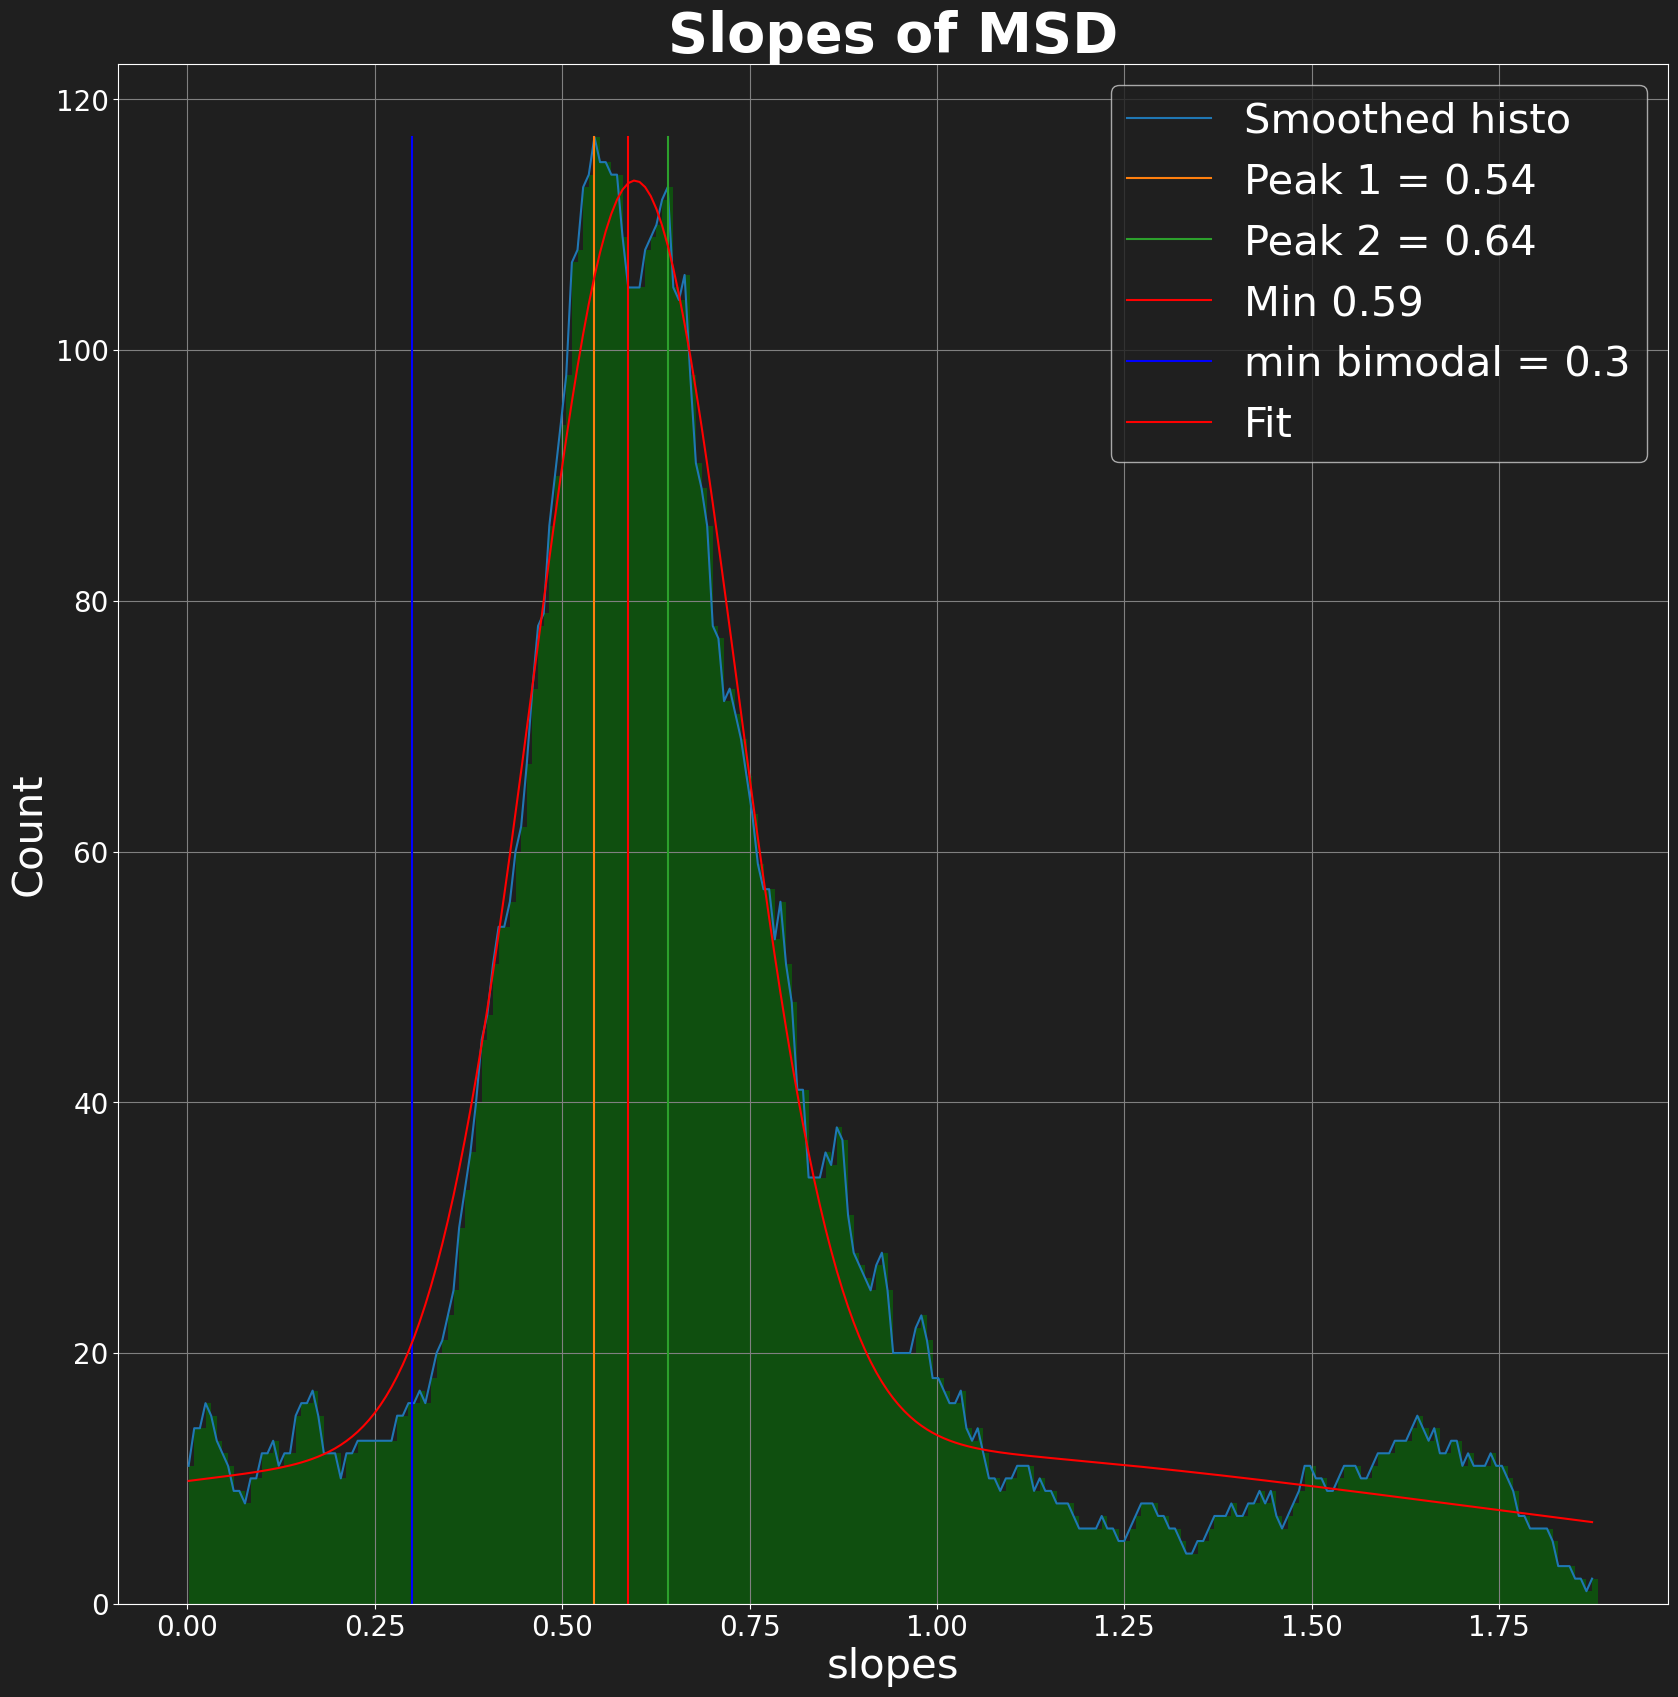

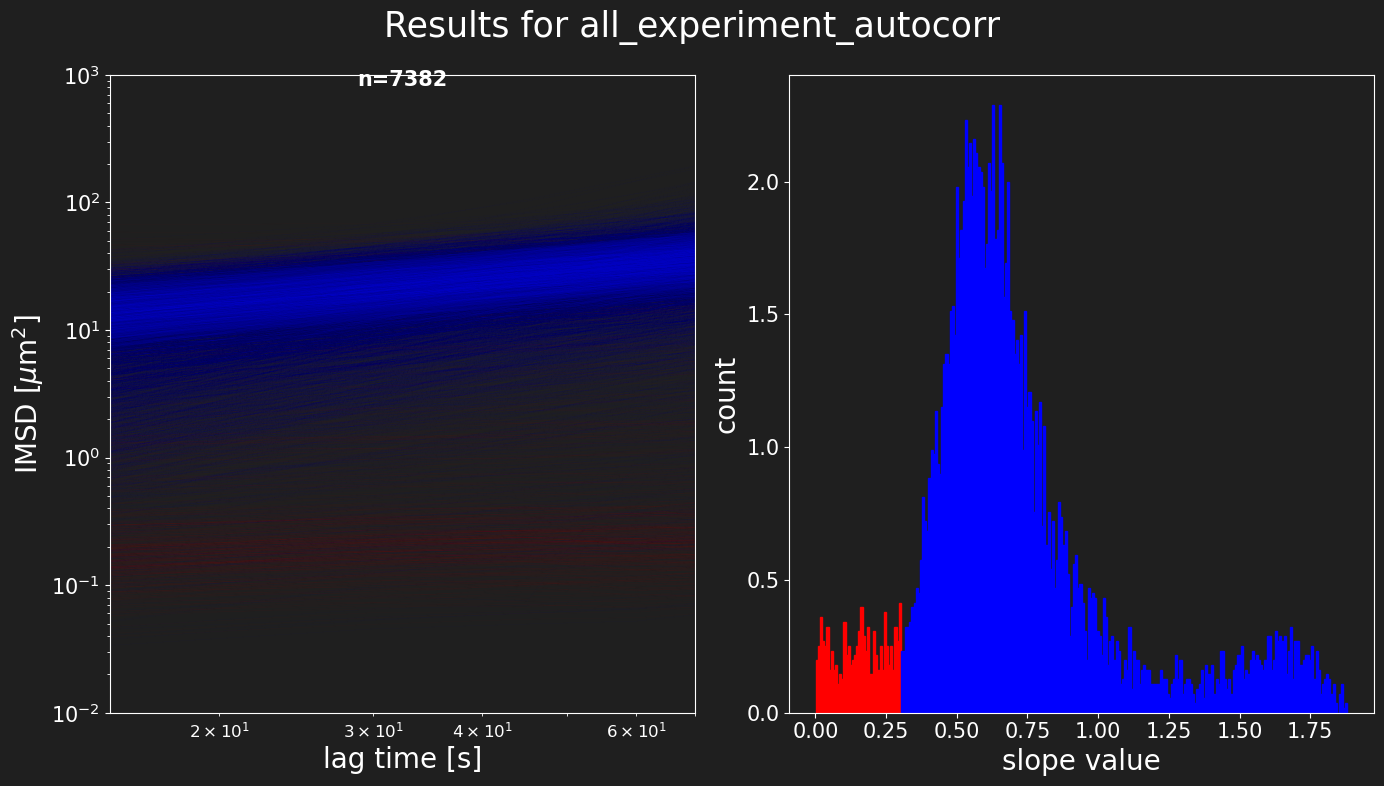

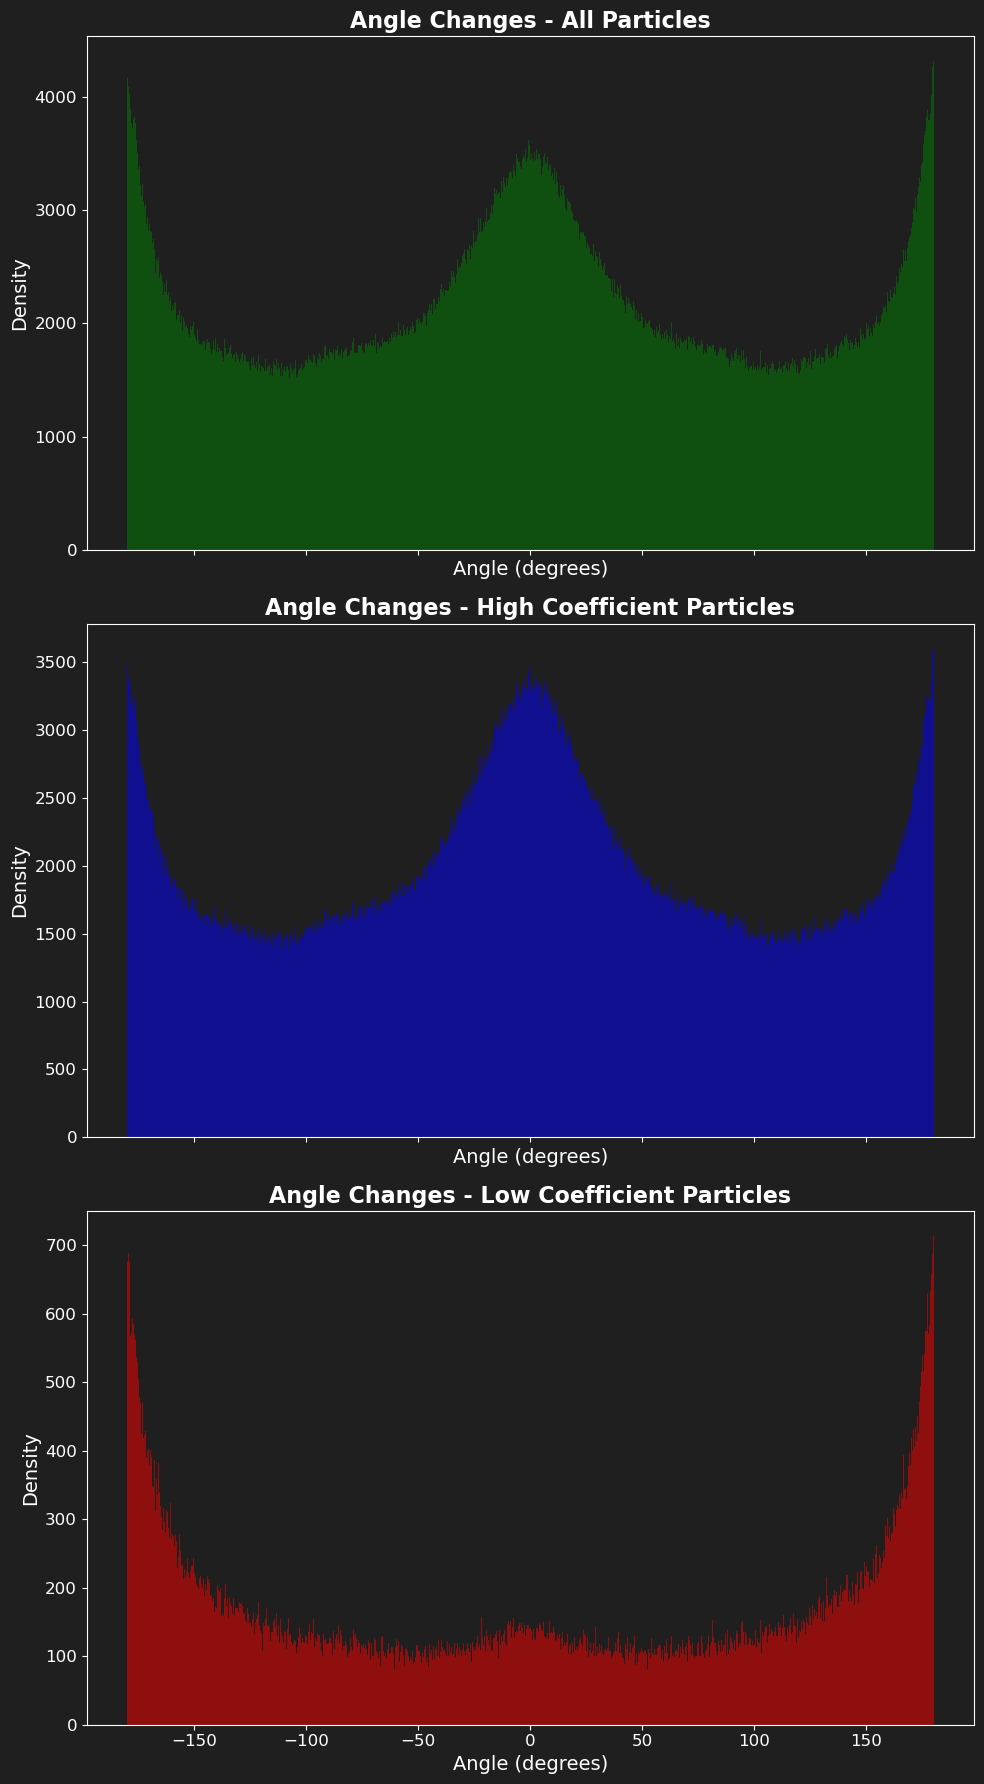

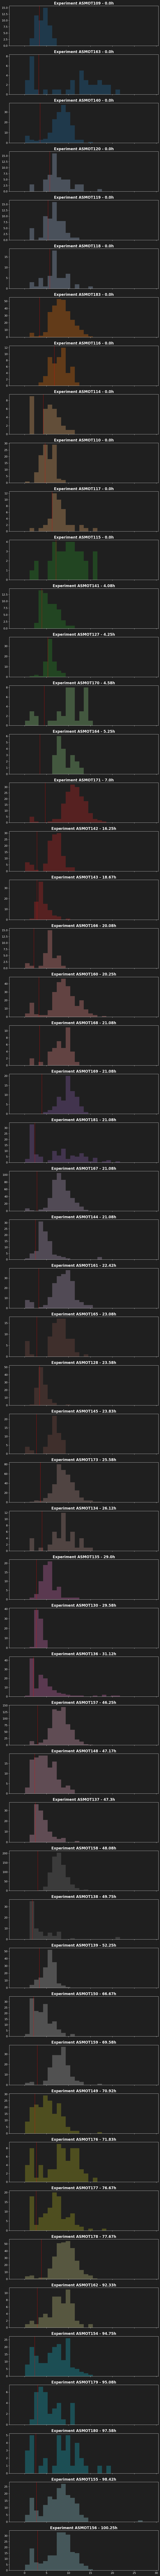

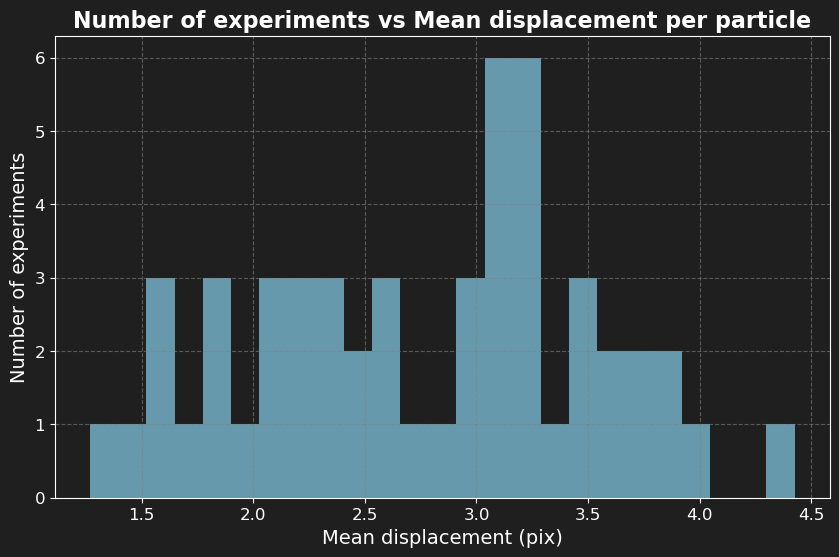

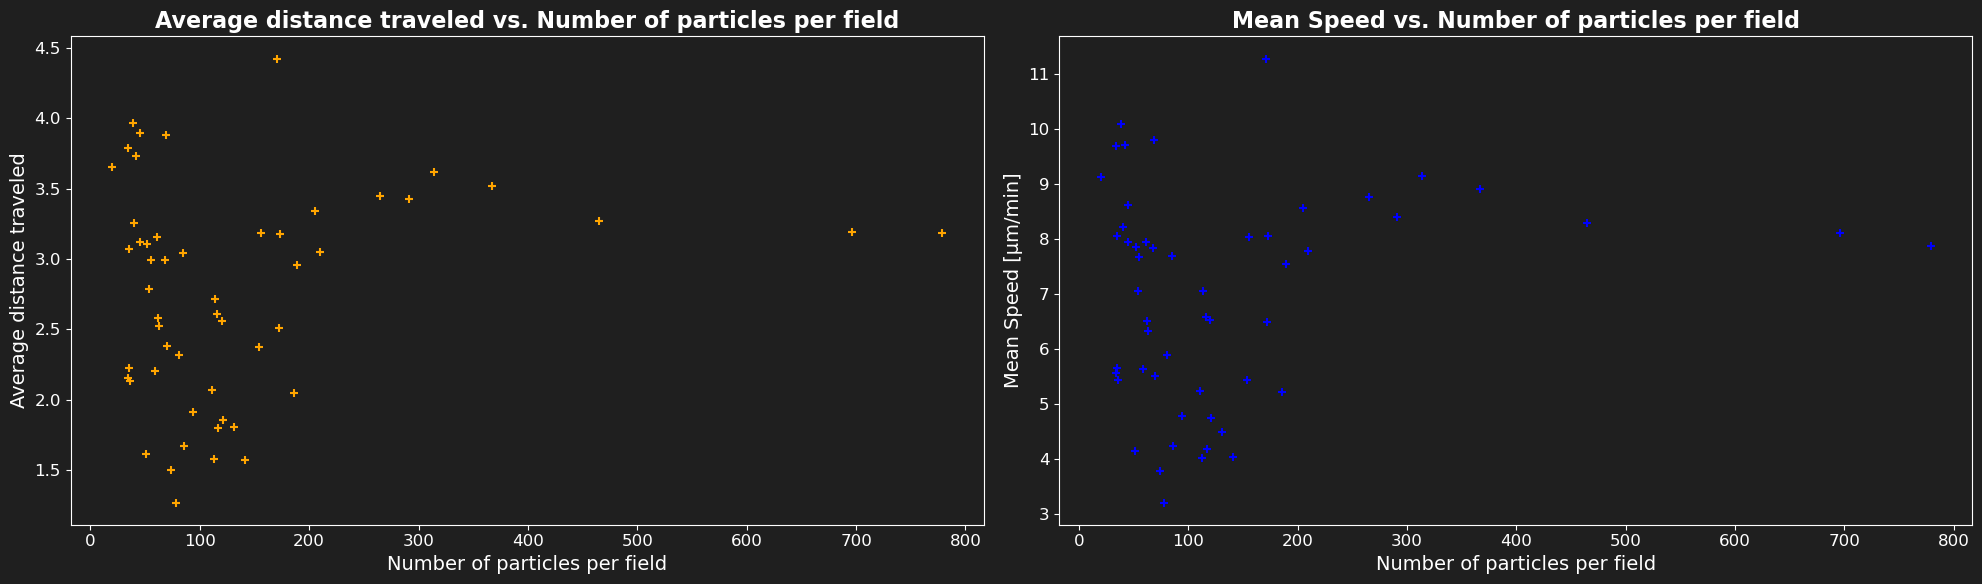

In [7]:
import os
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import trackpy as tp
import functions_analyze as lib
from typing import List, Dict
from matplotlib import colormaps

# Initialize
INITIAL_TIME = time.time()

# Experiment Parameters
TIME_FRAME = 15
SIZE_PIX = 0.637
FPS = 1 / TIME_FRAME

# General Paths
GENERAL_PATH = '/Users/souchaud/Desktop/Analyses/'
CONDITION_SIMPLE = 'CytoOne_HL5_10x'
CONDITION = f'{CONDITION_SIMPLE}_results_tracking'
PATHWAY_EXPERIMENT = [os.path.join(GENERAL_PATH, CONDITION, f, 'mosaic')
                      for f in os.listdir(os.path.join(GENERAL_PATH, CONDITION))
                      if os.path.isdir(os.path.join(GENERAL_PATH, CONDITION, f))]

path_save_pic = os.path.join(GENERAL_PATH, f'résultats_{CONDITION}_All')
os.makedirs(path_save_pic, exist_ok=True)

# Add Incubation Times to Data
conditions_to_values = {
    'ASMOT127': 4.25, 'ASMOT128': 23.58, 'ASMOT130': 29.58, 'ASMOT132': 4.33, 'ASMOT133': 23.12,
    'ASMOT134': 26.12, 'ASMOT135': 29, 'ASMOT136': 31.12, 'ASMOT137': 47.3, 'ASMOT138': 49.75,
    'ASMOT139': 52.25, 'ASMOT140': 0, 'ASMOT141': 4.08, 'ASMOT142': 16.25, 'ASMOT143': 18.67,
    'ASMOT144': 21.08, 'ASMOT145': 23.83, 'ASMOT146': 42.17, 'ASMOT147': 51.17, 'ASMOT148': 47.17,
    'ASMOT149': 70.92, 'ASMOT150': 66.67, 'ASMOT151': 71.17, 'ASMOT152': 76.33, 'ASMOT153': 78.33,
    'ASMOT154': 94.75, 'ASMOT155': 98.42, 'ASMOT156': 100.25, 'ASMOT157': 46.25, 'ASMOT158': 48.08,
    'ASMOT159': 69.58, 'ASMOT160': 20.25, 'ASMOT161': 22.42, 'ASMOT162': 92.33, 'ASMOT163': 0.0,
    'ASMOT164': 5.25, 'ASMOT165': 23.08, 'ASMOT166': 20.08, 'ASMOT167': 21.08, 'ASMOT168': 21.08,
    'ASMOT169': 21.08, 'ASMOT170': 4.58, 'ASMOT171': 7.00, 'ASMOT172': 24.00, 'ASMOT173': 25.58,
    'ASMOT174': 30.58, 'ASMOT175': 47.58, 'ASMOT176': 71.83, 'ASMOT177': 76.67, 'ASMOT178': 77.67,
    'ASMOT179': 95.08, 'ASMOT180': 97.58, 'ASMOT181': 21.08,
}

# Load Data
def load_data():
    data = lib.read_hdf5_all(
        pathway_experiment=PATHWAY_EXPERIMENT,
        name_file='filtered_final',
        nbr_frame_min=200,
        condition=CONDITION,
        drift=False,
        search_range=20,
        memory=5
    )
    data.sort_values(by='frame', inplace=True)
    data = data[data['frame'] < 340]
    data['time to incubation (hours)'] = data['experiment'].map(conditions_to_values).fillna(0.0)
    return data

DATA = load_data()

# Analysis
def analyze_data(data: pd.DataFrame):
    data['time (min)'] = data['frame'] * TIME_FRAME / 60
    data = lib.vit_instant_new(traj=data, lag_time=TIME_FRAME, pix_size=SIZE_PIX, triage=1)

    # Cumulative displacement
    data['cumulative displacement [um]'] = data.groupby('particle')['displacement [pix]'].cumsum() * SIZE_PIX

    # Start-End displacement
    start_end = pd.DataFrame()
    start_end['start-end [um]'] = SIZE_PIX * np.sqrt(
        data.groupby('particle').apply(lib.subtract_first_last, 'x')**2 +
        data.groupby('particle').apply(lib.subtract_first_last, 'y')**2
    )

    # Velocity medians
    medians = data.groupby('experiment')['VitInst [um/min]'].median()

    return data, start_end, medians

DATA, start_end, medians = analyze_data(DATA)

# Compute MSD
def compute_msd(data: pd.DataFrame):
    data['frame'] = pd.factorize(data['frame'])[0]
    imsd = tp.imsd(traj=data, mpp=SIZE_PIX, fps=FPS, max_lagtime=200, statistic='msd')
    return imsd

IMSD = compute_msd(DATA)

# Trajectory clustering with fit and cutoff
def trajectory_clustering(data: pd.DataFrame, imsd):
    LAG_TIME_FIT = 5
    COEF_INF, COEF_SUP, PART_COEF_INF, PART_COEF_SUP, CUTOFF = lib.traj_clustering_with_fit_cutoff(
        data, imsd=imsd, hist=True, lag_time_fit=LAG_TIME_FIT, micronperpixel=SIZE_PIX,
        fps=FPS, binsize=250, peak_height=50, peak_width=1, save=True, pathway_fig=path_save_pic,
        name='all_experiment_autocorr', img_type='png', plot=True, color_sup_inf=('blue', 'red'),
        cutoff_default=0.30
    )
    return PART_COEF_SUP, PART_COEF_INF

PART_COEF_SUP, PART_COEF_INF = trajectory_clustering(DATA, IMSD)

# Visualization
exp_hours = DATA.groupby('experiment')[['time to incubation (hours)']].first().reset_index()

def plot_velocity_histograms(all_mean_vitinst, medians, exp_hours):
    exp_hours_sorted = exp_hours.sort_values(by='time to incubation (hours)').reset_index(drop=True)
    experiments = exp_hours_sorted['experiment'].tolist()

    n_experiments = len(experiments)
    fig, axes = plt.subplots(n_experiments, 1, figsize=(10, 3 * n_experiments), sharex=True)
    axes = np.atleast_1d(axes)

    global_min = all_mean_vitinst['VitInst [um/min]'].min()
    global_max = all_mean_vitinst['VitInst [um/min]'].max()
    delta = (global_max - global_min) * 0.1
    global_min -= delta
    global_max += delta

    palette = colormaps['tab20']
    colors = [palette(i / n_experiments) for i in range(n_experiments)]

    for idx, ax in enumerate(axes):
        exp = experiments[idx]
        hour = exp_hours_sorted.iloc[idx]['time to incubation (hours)']

        data_exp = all_mean_vitinst[all_mean_vitinst['experiment'] == exp]
        ax.hist(
            data_exp['VitInst [um/min]'],
            bins=30,
            alpha=0.3,
            range=(global_min, global_max),
            color=colors[idx]
        )
        ax.set_title(f'Experiment {exp} - {hour}h')
        ax.axvline(medians.loc[exp], color='red', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.show()

def plot_mean_displacement_histogram(mean_sum, path_save_pic, CONDITION_SIMPLE, IMG_TYPE):
    plt.figure(figsize=(10, 6))
    plt.hist(mean_sum, bins=25, color='skyblue', alpha=0.7)
    plt.title("Number of experiments vs Mean displacement per particle", fontsize=16)
    plt.xlabel("Mean displacement (pix)", fontsize=14)
    plt.ylabel("Number of experiments", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(os.path.join(path_save_pic, f"Mean_displacement_per_particle_{CONDITION_SIMPLE}.{IMG_TYPE}"), format=IMG_TYPE)
    plt.show()

def plot_results_vs_particles(result_df, path_save_pic, CONDITION_SIMPLE, img_type):
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    ax1, ax2 = axes.flatten()
    ax1.scatter(result_df['nombre_part_par_champs'], result_df['mean_sum'], marker='+', color='orange')
    ax1.set_title('Average distance traveled vs. Number of particles per field')
    ax1.set_xlabel('Number of particles per field')
    ax1.set_ylabel('Average distance traveled')
    ax2.scatter(result_df['nombre_part_par_champs'], result_df['mean_speed [um/min]'], marker='+', color='blue')
    ax2.set_title('Mean Speed vs. Number of particles per field')
    ax2.set_xlabel('Number of particles per field')
    ax2.set_ylabel('Mean Speed [μm/min]')
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(path_save_pic, f"Results_vs_particles_{CONDITION_SIMPLE}.{img_type}"), format=img_type)

def compute_angle_changes(df):
    df = df.copy()
    df.sort_values(by=['particle', 'frame'], inplace=True)
    df['dir_x'] = df.groupby('particle')['x'].diff().fillna(0)
    df['dir_y'] = df.groupby('particle')['y'].diff().fillna(0)
    df['dir_x_next'] = df.groupby('particle')['dir_x'].shift(-1)
    df['dir_y_next'] = df.groupby('particle')['dir_y'].shift(-1)
    df.dropna(subset=['dir_x_next', 'dir_y_next'], inplace=True)

    def angle_between_directions(row):
        dx1, dy1 = row['dir_x'], row['dir_y']
        dx2, dy2 = row['dir_x_next'], row['dir_y_next']
        angle_initial = np.arctan2(dy1, dx1)
        angle_final = np.arctan2(dy2, dx2)
        angle_change = angle_final - angle_initial
        angle_change = (angle_change + np.pi) % (2 * np.pi) - np.pi
        return np.degrees(angle_change)

    df['angle_change'] = df.apply(angle_between_directions, axis=1)
    return df

df_sup = compute_angle_changes(DATA[DATA['particle'].isin(PART_COEF_SUP)])
df_inf = compute_angle_changes(DATA[DATA['particle'].isin(PART_COEF_INF)])

def plot_angle_histograms(df_sup, df_inf):
    fig, axes = plt.subplots(3, 1, figsize=(10, 18), sharex=True)
    df_all = pd.concat([df_sup, df_inf])
    axes[0].hist(df_all['angle_change'], bins=1000, alpha=0.5, color='green')
    axes[0].set_title('Angle Changes - All Particles')
    axes[0].set_xlabel('Angle (degrees)')
    axes[0].set_ylabel('Density')

    axes[1].hist(df_sup['angle_change'], bins=1000, color='blue', alpha=0.5)
    axes[1].set_title('Angle Changes - High Coefficient Particles')
    axes[1].set_xlabel('Angle (degrees)')
    axes[1].set_ylabel('Density')

    axes[2].hist(df_inf['angle_change'], bins=1000, color='red', alpha=0.5)
    axes[2].set_title('Angle Changes - Low Coefficient Particles')
    axes[2].set_xlabel('Angle (degrees)')
    axes[2].set_ylabel('Density')

    plt.tight_layout()
    plt.savefig(os.path.join(path_save_pic, 'Angle_Changes_Histograms.png'), format='png')
    plt.show()

plot_angle_histograms(df_sup, df_inf)

# Mean instantaneous velocities per particle per experiment
all_mean_vitinst = DATA.groupby(['experiment', 'particle'])['VitInst [um/min]'].mean().reset_index()
plot_velocity_histograms(all_mean_vitinst, medians, exp_hours)

# Mean displacement histogram
mean_sum = DATA.groupby('experiment')['displacement [pix]'].mean()
plot_mean_displacement_histogram(mean_sum, path_save_pic, CONDITION_SIMPLE, 'png')

# Results in function of number of particles per field
result_df = pd.DataFrame({
    'nombre_part_par_champs': DATA.groupby('experiment')['particle'].nunique(),
    'mean_sum': mean_sum,
    'mean_speed [um/min]': all_mean_vitinst.groupby('experiment')['VitInst [um/min]'].mean()
}).reset_index()
plot_results_vs_particles(result_df, path_save_pic, CONDITION_SIMPLE, 'png')
